# Traffic Density Trends
    Joseph Antony
    18th June 2023

In [1]:
import warnings
import numpy as np

import polars as pl
pl.enable_string_cache(True)

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="ticks", palette="muted", color_codes=True)

warnings.filterwarnings("ignore")

plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.weight'] = 'bold'

In [2]:
%%time
select_cols = ['DATE_TIME', 'GEOHASH', 'NUMBER_OF_VEHICLES', 'DISTRICT']

pl_df = (
    pl.scan_parquet("datasets/00_tr_df_merged/tr_ist_td_merged_full.zstd")
    .select(select_cols,
            pl.col('DATE_TIME').dt.year().alias('YEAR').cast(pl.UInt16),
            pl.col('DATE_TIME').dt.month().alias('MONTH').cast(pl.UInt8),
            pl.col('DATE_TIME').dt.hour().alias('HOUR').cast(pl.UInt8),
            pl.col('DATE_TIME').dt.weekday().alias('DAYOFWEEK').cast(pl.UInt8))
).collect(streaming=True)

pl_df.head()

Wall time: 19.5 s


DATE_TIME,GEOHASH,NUMBER_OF_VEHICLES,DISTRICT,YEAR,MONTH,HOUR,DAYOFWEEK
datetime[ns],cat,u16,cat,u16,u8,u8,u8
2020-01-01 00:00:00,"""sxkbj3""",97,"""Gebze""",2020,1,0,3
2020-01-01 01:00:00,"""sxkbj3""",58,"""Gebze""",2020,1,1,3
2020-01-01 02:00:00,"""sxkbj3""",40,"""Gebze""",2020,1,2,3
2020-01-01 03:00:00,"""sxkbj3""",33,"""Gebze""",2020,1,3,3
2020-01-01 04:00:00,"""sxkbj3""",25,"""Gebze""",2020,1,4,3


### Top and Bottom mean traffic density areas

In [3]:
(
    pl_df.lazy()
    .groupby(['GEOHASH', 'DISTRICT'])
    .agg(pl.col('NUMBER_OF_VEHICLES').mean())
    .top_k(10, by='NUMBER_OF_VEHICLES')
    .collect(streaming=True)
)

GEOHASH,DISTRICT,NUMBER_OF_VEHICLES
cat,cat,f64
"""sxk3xe""","""Başakşehir""",520.230092
"""sxk3xd""","""Bağcılar""",498.876096
"""sxk985""","""Bağcılar""",462.405805
"""sxk9pq""","""Ataşehir""",429.93332
"""sxkbgk""","""Pendik""",427.00956
"""sxk3x7""","""Başakşehir""",423.657792
"""sxkbge""","""Pendik""",412.134526
"""sxk3rs""","""Bağcılar""",407.144326
"""sxk9nx""","""Ümraniye""",404.361774


In [4]:
(
    pl_df.lazy()
    .groupby(['GEOHASH', 'DISTRICT'])
    .agg(pl.col('NUMBER_OF_VEHICLES').mean())
    .bottom_k(10, by='NUMBER_OF_VEHICLES')
    .collect(streaming=True)
)

GEOHASH,DISTRICT,NUMBER_OF_VEHICLES
cat,cat,f64
"""sxk6rb""","""Arnavutköy""",7.083059
"""sxkb75""","""Tuzla""",7.913857
"""sxkd8d""","""Eyüpsultan""",7.964433
"""sxkcfk""","""Çekmeköy""",8.400014
"""sx7ckc""","""Marmaraereğlis…",8.481394
"""sx7fqz""","""Silivri""",8.646484
"""sx7cxm""","""Silivri""",8.796155
"""sxk1fu""","""Silivri""",8.873801
"""sx7cwd""","""Silivri""",8.997464


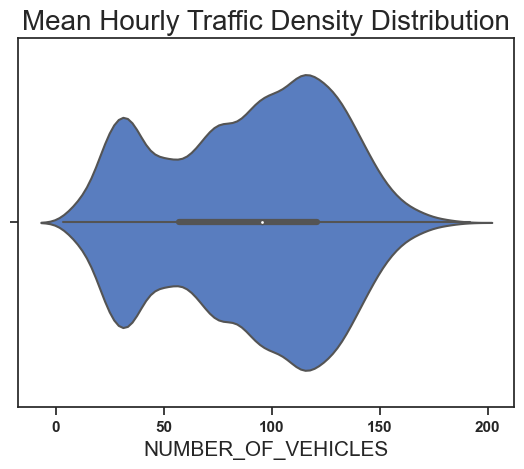

In [5]:
temp_df = (
    pl_df.lazy()
    .groupby('DATE_TIME')
    .agg(pl.col('NUMBER_OF_VEHICLES').mean())
    .collect(streaming=True)
    .to_pandas()
)

ax = sns.violinplot(
    x = temp_df['NUMBER_OF_VEHICLES'],
    orient='h', 
)

ax.set_title("Mean Hourly Traffic Density Distribution");

    The mean hourly traffic density violinplot shows a bimodal distribution, suggesting that there are two distinct peaks or high points in traffic density.

### Monthly Traffic Density Pattern

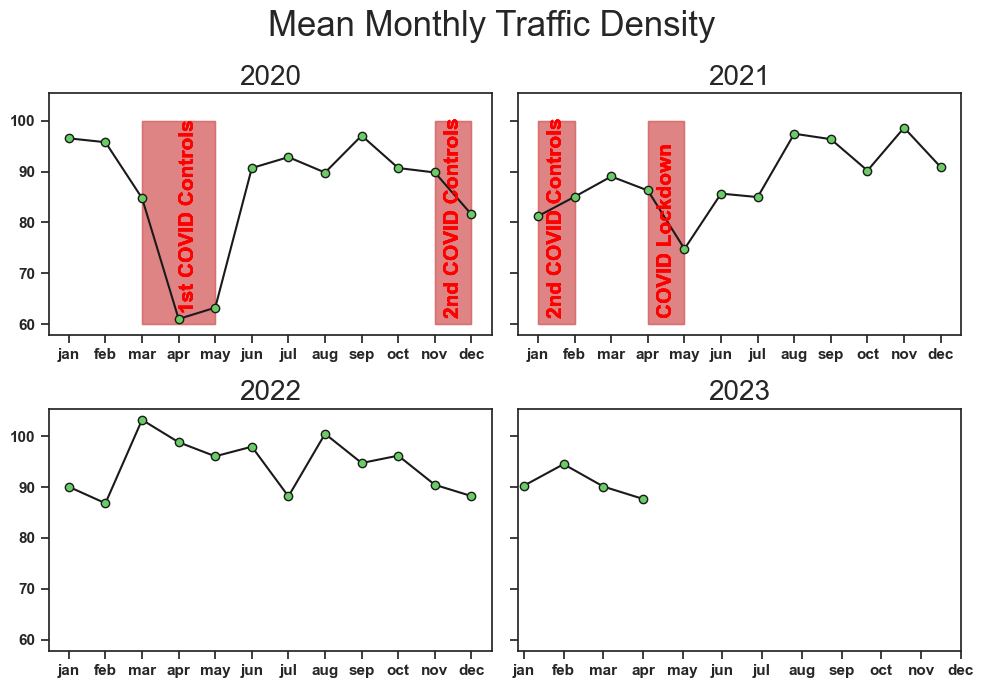

In [6]:
# Plotting Monthly Patterns
month_labels=['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

fig, axes = plt.subplots(2, 2, figsize=(10, 7), sharey=True, tight_layout=True)

for year, ax in zip([2020, 2021, 2022, 2023], axes.flatten()):

    (
        pl_df.lazy()
        .filter(pl.col('YEAR').eq(year))
        .groupby('MONTH')
        .agg(pl.col('NUMBER_OF_VEHICLES').mean())
        .sort('MONTH')
        .collect(streaming=True)
        .to_pandas()
        .set_index('MONTH')
        .plot(ax=ax, marker="o", mfc="g", mec="k", color='k')
    )

    ax.set_title(year)
    ax.set_xlabel("")
    ax.legend().remove()

    ax.set_xticks(ticks=np.arange(1, 13, 1), labels=month_labels)

    # Covid Restriction Months in 2020
    axes.flatten()[0].fill_between(x=(3, 5), y1=60, y2=100, color='r', alpha = 0.3)
    axes.flatten()[0].text(4, 63, "1st COVID Controls", fontsize=15, rotation=90, c='red')
    
    axes.flatten()[0].fill_between(x=(11, 12), y1=60, y2=100, color='r', alpha = 0.3)
    axes.flatten()[0].text(11.25, 62, "2nd COVID Controls", fontsize=15, rotation=90, c='red')


    # Covid Lockdown months in 2021
    axes.flatten()[1].fill_between(x=(1, 2), y1=60, y2=100, color='r', alpha = 0.3)
    axes.flatten()[1].text(1.25, 62, "2nd COVID Controls", fontsize=15, rotation=90, c='red')

    axes.flatten()[1].fill_between(x=(4, 5), y1=60, y2=100, color='r', alpha = 0.3)
    axes.flatten()[1].text(4.25, 62, "COVID Lockdown", fontsize=15, rotation=90, c='red')

    plt.suptitle("Mean Monthly Traffic Density", size=25);

    The above plots illustrates monthly mean traffic density from 2020 to 2023. The shaded regions for the year 2020 represents the time periods when the Turkish government placed restrictions to prevent spread of COVID. (https://en.wikipedia.org/wiki/COVID-19_pandemic_in_Turkey). Traffic density was significantly low from March to May 2020.
    
    During 2021, Turkish government announced nationwide lockdown from April 29 to May 17. The shaded region in 2021 shows a significant drop in traffic density as a result.
    
    For the year 2022, the lowest traffic density is noted during February, followed by July, although the cause is not known.
    Overall, there is no discernable monthly seasonality in traffic density.

### Hourly Traffic Density Pattern

In [7]:
month_map = {str(i+1) : mnth for i, mnth in enumerate(month_labels)}
month_map

{'1': 'jan',
 '2': 'feb',
 '3': 'mar',
 '4': 'apr',
 '5': 'may',
 '6': 'jun',
 '7': 'jul',
 '8': 'aug',
 '9': 'sep',
 '10': 'oct',
 '11': 'nov',
 '12': 'dec'}

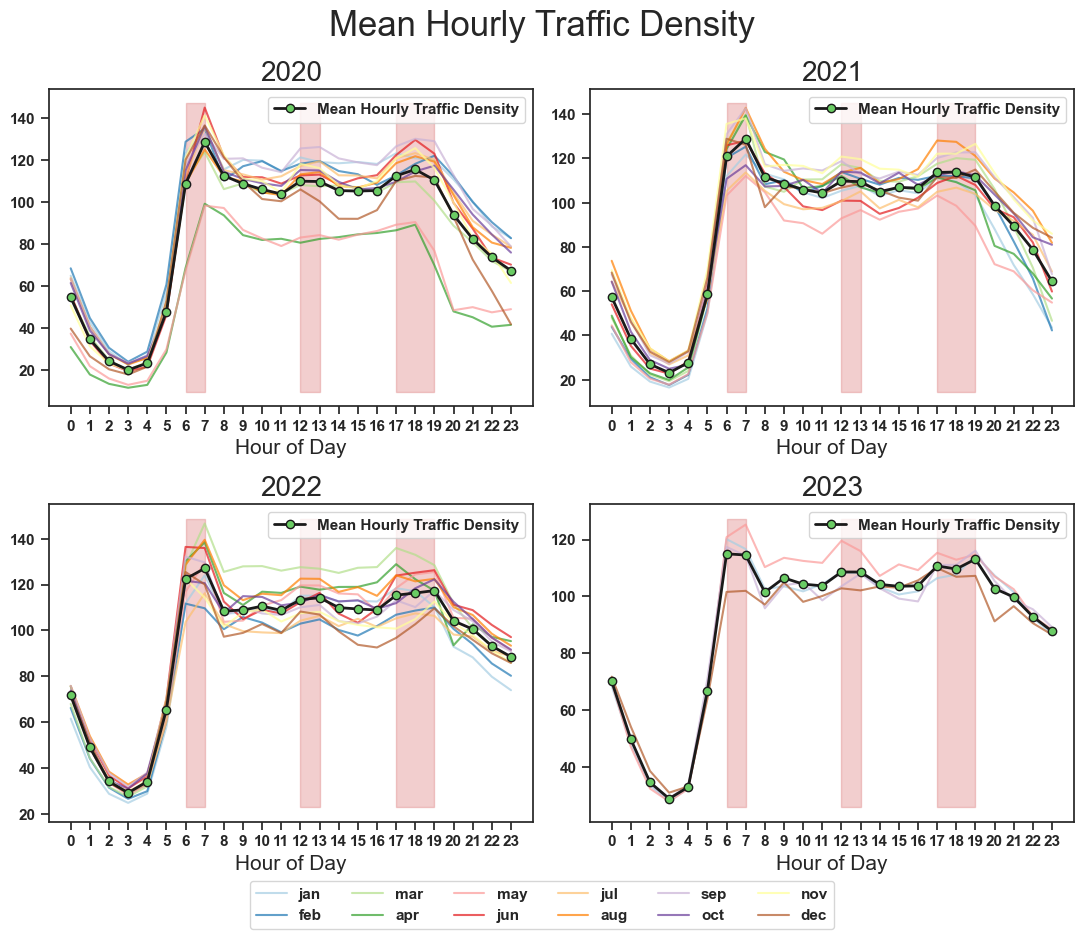

In [8]:
# Plotting Hourly Patterns
fig, axes = plt.subplots(2, 2, figsize=(11, 9), tight_layout=True)

for year, ax in zip([2020, 2021, 2022, 2023], axes.flatten()):

    temp_df = (
        pl_df.lazy()
        .filter(pl.col('YEAR').eq(year))
        .groupby(['MONTH', 'HOUR'])
        .agg(pl.col('NUMBER_OF_VEHICLES').mean())
        .sort(['MONTH', 'HOUR'])
        .collect(streaming=True)
        .pivot(index='HOUR', columns='MONTH', values='NUMBER_OF_VEHICLES')
        .to_pandas()
        .rename(columns=month_map)
        .set_index('HOUR')
    )

    # Getting upper and lower y limits for shading density regions
    low_lim = temp_df.min(axis=1).min() - 2
    max_lim = temp_df.max(axis=1).max() + 2

    # Monthly Mean plots
    temp_df.plot(ax=ax, colormap='Paired', alpha=0.7)

    # Overall Mean plot
    temp_df.mean(axis=1).plot(ax=ax, c='k', lw=2, marker="o", mfc="g", mec="k", label='Mean Hourly Traffic Density')
    
    # To display on the Overall Mean plot legend
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[-1:], labels[-1:])

    ax.set_title(year)
    ax.set_xticks(ticks=np.arange(0, 24, 1))
    ax.set_xlabel("Hour of Day")
    
    # Shading Regions of peak Traffic density
    ax.fill_between(x=(6, 7), y1=max_lim, y2=low_lim, color='r', alpha = 0.3)
    ax.fill_between(x=(12, 13), y1=max_lim, y2=low_lim, color='r', alpha = 0.3)
    ax.fill_between(x=(17, 19), y1=max_lim, y2=low_lim, color='r', alpha = 0.3)
    
# To display Month legends
handles, labels = axes.flatten()[0].get_legend_handles_labels()
fig.legend(handles=handles, labels=month_labels, loc='lower center', ncol=6, bbox_to_anchor=(0.5, -0.05));

plt.suptitle("Mean Hourly Traffic Density", size=25);

    The above plots depicts average hourly traffic density for all months by year. For all years and months, there are three distinct peak traffic density hours. The highest traffic density is from 6am to 7am. Then then a low traffic density peak is noticed from 12pm to 1pm. Finally, a mid-traffic density peak is observed from 5pm to 7pm.

### Weekly Traffic Density

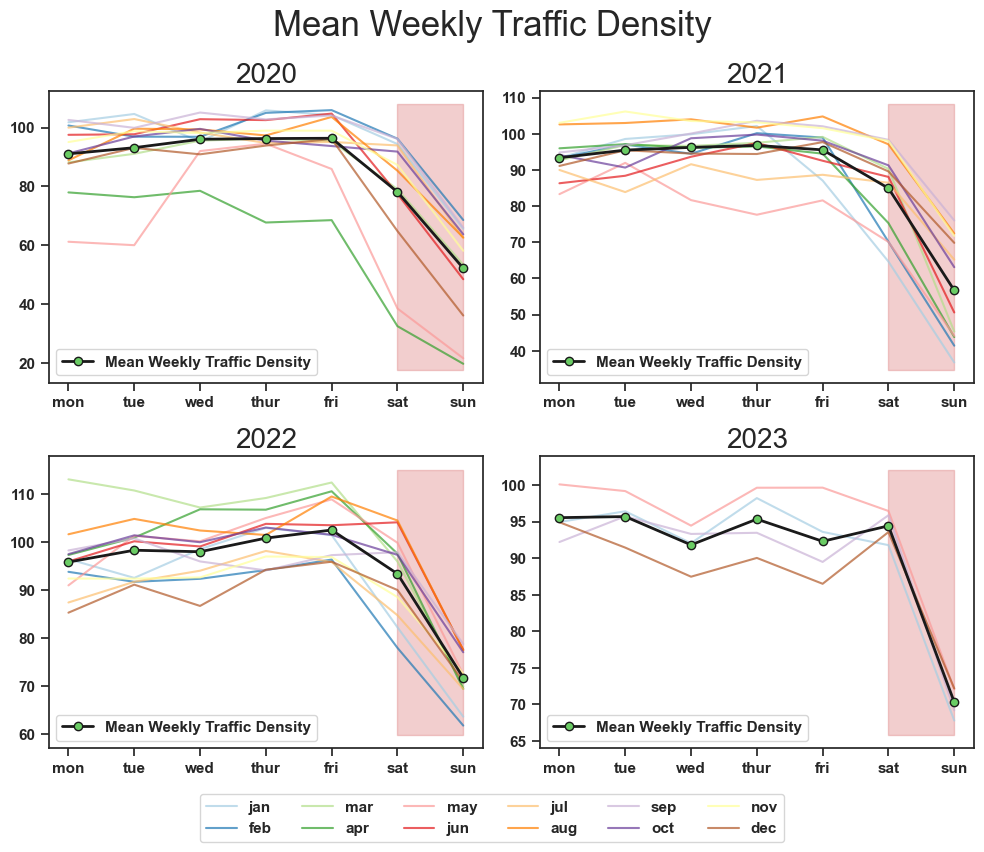

In [9]:
# Plotting Weekly Pattern
weekday_labels=["mon", "tue", "wed", "thur", "fri", "sat", "sun"]

fig, axes = plt.subplots(2, 2, figsize=(10, 8), tight_layout=True)

for year, ax in zip([2020, 2021, 2022, 2023], axes.flatten()):

    # Filtering year, followed by grouping by Month and day of week and taking avg traffic density. Then saving it to a temp df
    temp_df = (
        pl_df.lazy()
        .filter(pl.col('YEAR').eq(year))
        .groupby(['MONTH', 'DAYOFWEEK'])
        .agg(pl.col('NUMBER_OF_VEHICLES').mean())
        .sort(['MONTH', 'DAYOFWEEK'])
        .collect(streaming=True)
        .pivot(index='DAYOFWEEK', columns='MONTH', values='NUMBER_OF_VEHICLES')
        .to_pandas()
        .rename(columns=month_map)
        .set_index('DAYOFWEEK')
    )

    # Getting upper and lower y limits for shading density regions
    low_lim = temp_df.min(axis=1).min() - 2
    max_lim = temp_df.max(axis=1).max() + 2

    # Monthly Mean plots
    temp_df.plot(ax=ax, colormap='Paired', alpha=0.7)

    # Overall Mean plot
    temp_df.mean(axis=1).plot(ax=ax, c='k', lw=2, marker="o", mfc="g", mec="k", label='Mean Weekly Traffic Density')
    
    # To display on the Overall Mean plot legend
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[-1:], labels[-1:])

    # Shading Regions of low Traffic Density
    ax.fill_between(x=(6, 7), y1=max_lim, y2=low_lim, color='r', alpha = 0.3)

    ax.set_title(year)
    ax.set_xticks(ticks=np.arange(1, 8, 1), labels=weekday_labels)
    ax.set_xlabel("")

# To display Month legends
handles, _ = axes.flatten()[0].get_legend_handles_labels()
fig.legend(handles=handles, labels=month_labels, loc='lower center', ncol=6, bbox_to_anchor=(0.5, -0.07))

plt.suptitle("Mean Weekly Traffic Density", size=25);

    The above plots depicts average weekly traffic density for all months by year. Traffic density is lowest during weekends (Saturday and Sunday)

### Hourly Traffic Density by Day Of Week

In [10]:
wd_map = {str(i+1):wd for i, wd in enumerate(weekday_labels)}
wd_map

{'1': 'mon',
 '2': 'tue',
 '3': 'wed',
 '4': 'thur',
 '5': 'fri',
 '6': 'sat',
 '7': 'sun'}

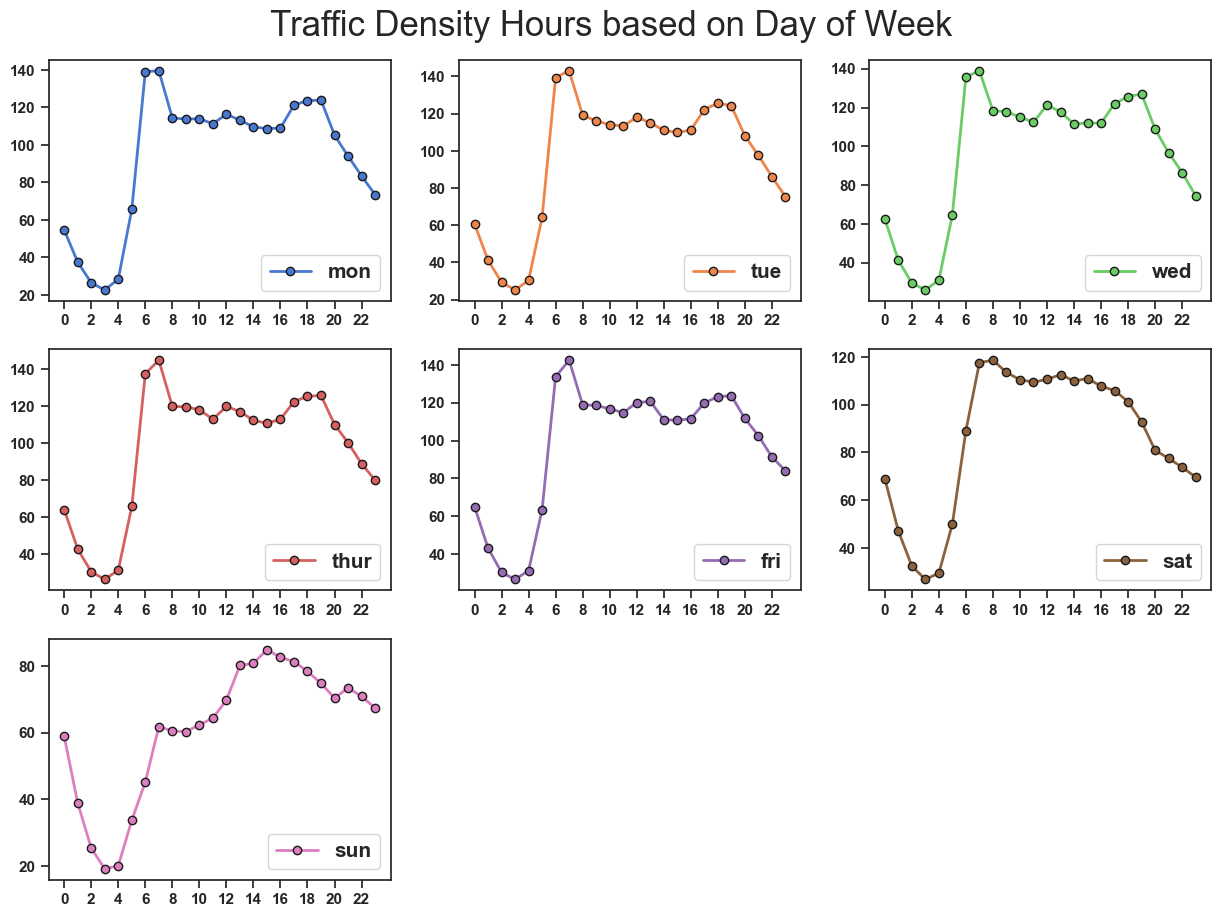

In [11]:
axes = (
    pl_df.lazy()
    .groupby(['DAYOFWEEK', 'HOUR'])
    .agg(pl.col('NUMBER_OF_VEHICLES').mean())
    .sort(['DAYOFWEEK', 'HOUR'])
    .collect(streaming=True)
    .pivot(index='HOUR', columns='DAYOFWEEK', values='NUMBER_OF_VEHICLES')
    .rename(wd_map)
    .to_pandas()
    .set_index('HOUR')
    .plot(subplots=True, figsize=(15, 10), layout=(3, 3), sharex=False, lw=2, marker="o", mec="k")
);

for i, ax in enumerate(axes.flatten()[:7]):
    ax.set_xlabel("")
    ax.set_xticks(np.arange(0, 24, 2))
    ax.legend(fontsize=15, loc="lower right")

plt.suptitle("Traffic Density Hours based on Day of Week", fontsize=25)
plt.subplots_adjust(top=0.93);

    The above plots depicts how traffic density for each hour in a day differs based on day of the week. From monday to Friday, the pattern is the same. But the traffic density pattern changes on weekends. Especially on sunday, the peak hours are from 12pm to 8pm.

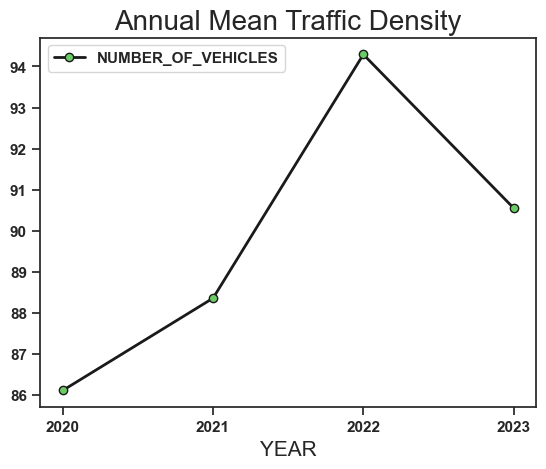

In [12]:
ax = (
    pl_df.lazy()
    .groupby('YEAR')
    .agg(pl.col('NUMBER_OF_VEHICLES').mean())
    .sort('YEAR')
    .collect(streaming=True)
    .to_pandas()
    .set_index('YEAR')
    .plot(c='k', lw=2, marker="o", mfc="g", mec="k")
)

ax.set_xticks([2020, 2021, 2022, 2023])
ax.set_title("Annual Mean Traffic Density");

    The above plot illustrates annual mean traffic density. 2022 seems to have highest traffic density compared to 2020 and 2021. But there were certain restrictions during those years due to COVID.